In [30]:
import pandas as pd
import numpy as np

import mlflow
from mlflow import catboost
from catboost import CatBoostClassifier, Pool, cv
import json
import shap

import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
data = pd.read_csv(r'..\data\cat_boostData.csv')
X, y = data.drop(['Churn'], axis=1), data['Churn']
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features.append('SeniorCitizen')

dataPool = Pool(X, y, cat_features=cat_features)
with open(r"..\\data\run_ids.txt", "rb") as file:
    uri = json.load(file)

In [23]:
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,overpayment
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,0.00
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,-46.80
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,0.45
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,-62.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,10.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,-44.70
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,-67.50
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,20.85
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,9.00


In [24]:
catBoostModel = mlflow.catboost.load_model(uri['CatBoost'])

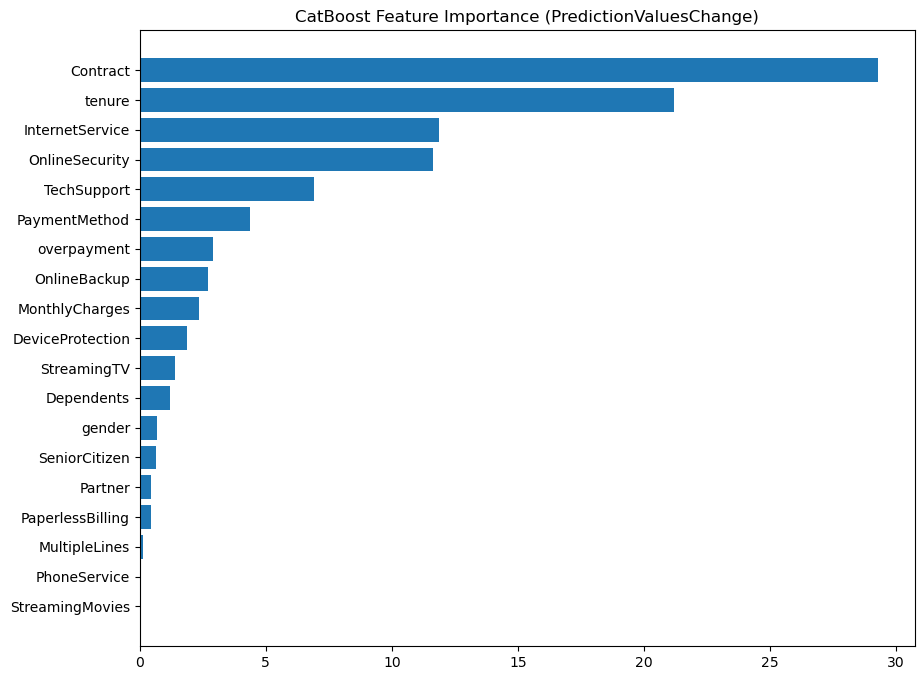

In [31]:
feature_importance = catBoostModel.get_feature_importance(dataPool)
feature_names = X.columns
df_fi = pd.DataFrame({"feature": feature_names, "importance": feature_importance})
df_fi = df_fi.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(df_fi["feature"], df_fi["importance"])
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance (PredictionValuesChange)")
plt.show()

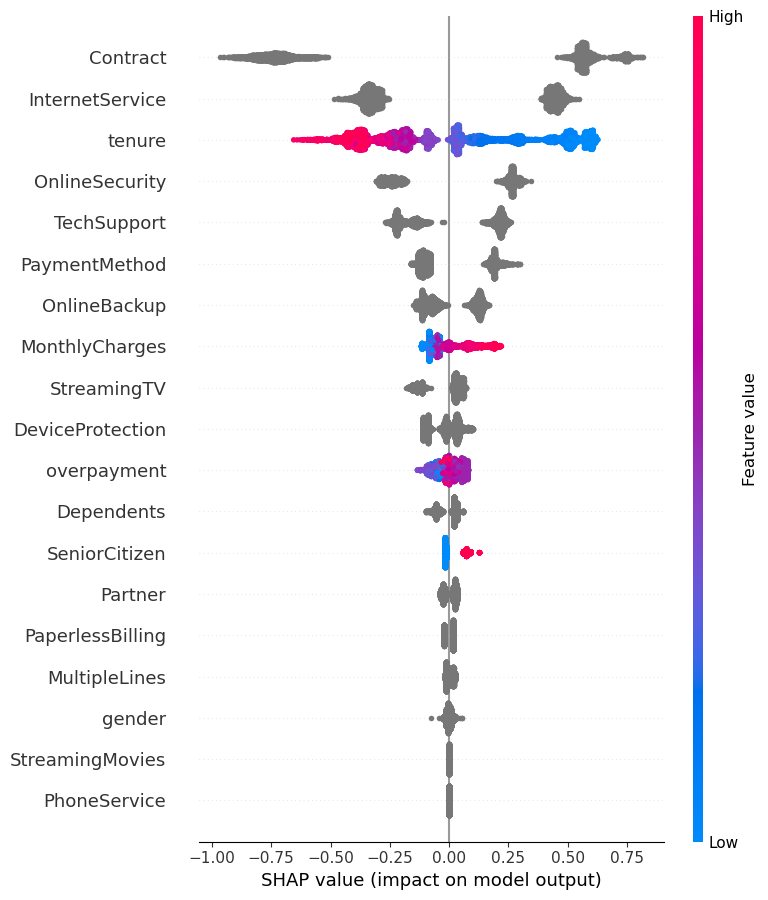

In [59]:
explainer = shap.TreeExplainer(catBoostModel)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="dot")


Числовые признаки:
- 1) **Tenure**
    Видна закономерность, старые клиенты и дальше остаются. А новые клиенты, часто отказываются от услуг оператора. **Новые клиенты = основная зона риска**
- 2) **MonthlyCharges**
    Высокие цены на тарифы один из важнейщих факторов оттока.

Категориальные признаки:
- 1) **Senior Citizen**
    Пенсионеры маленькая группа клиентов, но среди них очень высокий отток.

С остальными признаками есть проблема - на них нет отношения порядка, поэтому они не окрашены. Сложно понять их значения. Рассмотрим топ категориальных признаков отдельно.

In [67]:
def plot_categorical_shap(shap_values, df, feature):
   
    if shap_values.shape[1] == df.shape[1] + 1:
        shap_values = shap_values[:, :-1]   # удаляем base_value
    elif shap_values.shape[1] != df.shape[1]:
        raise ValueError(
            f"Shape mismatch: shap_values {shap_values.shape} vs df {df.shape}"
        )

   
    feat_idx = list(df.columns).index(feature)

   
    df_encoded = df.copy()
    df_encoded[feature + "_encoded"] = df[feature].astype("category").cat.codes
    hue_values = df_encoded[feature + "_encoded"].values

 
    shap_feat = shap_values[:, feat_idx]

 
    plt.figure(figsize=(4, 2))

  
    df_encoded[feature + "_encoded"] = df[feature].astype("category").cat.codes
    codes = df_encoded[feature + "_encoded"].values
    categories = df[feature].astype("category").cat.categories

  
    scatter = plt.scatter(
        shap_feat,      
        codes,          
        c=codes,        
        cmap="tab20",
        alpha=0.75
    )

    plt.yticks(
        ticks=range(len(categories)),
        labels=categories
    )

    # ❌ Удаляем шкалу справа
    # (просто НЕ создаём colorbar)

    plt.xlabel("SHAP value")
    plt.ylabel(feature)
    plt.title(f"Vertical SHAP dependence plot for '{feature}'")
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()
    shap_by_cat = (
        pd.DataFrame({
            "category": df[feature],
            "shap_value": shap_feat
        })
        .groupby("category")["shap_value"]
        .mean()
        .sort_values()
    )

    
    display(shap_by_cat.to_frame(name="mean_shap"))


In [ ]:
top_fi = df_fi.iloc[:10, 0].to_list()
top_cat_features = set(cat_features) & set(top_fi)

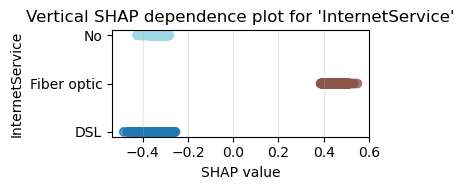

,mean_shap
category,
DSL,-0.334585
No,-0.331652
Fiber optic,0.446344


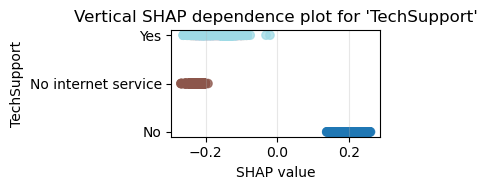

,mean_shap
category,
No internet service,-0.222125
Yes,-0.159762
No,0.212811


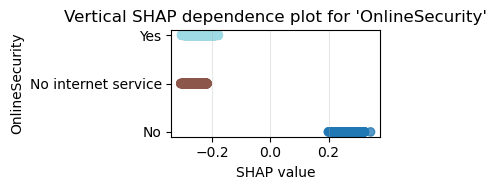

,mean_shap
category,
No internet service,-0.261629
Yes,-0.235821
No,0.266560


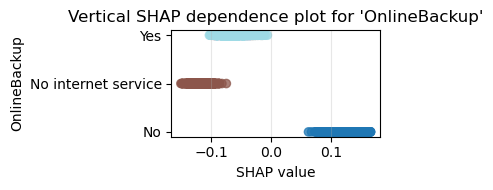

,mean_shap
category,
No internet service,-0.114030
Yes,-0.065058
No,0.122193


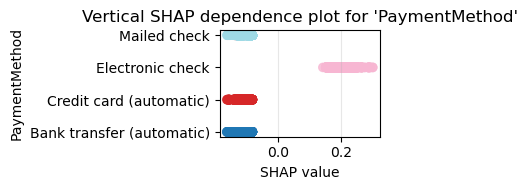

,mean_shap
category,
Bank transfer (automatic),-0.111562
Credit card (automatic),-0.111144
Mailed check,-0.103963
Electronic check,0.193707


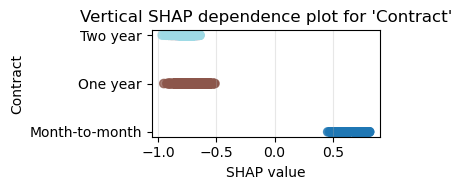

,mean_shap
category,
Two year,-0.754913
One year,-0.714751
Month-to-month,0.588392


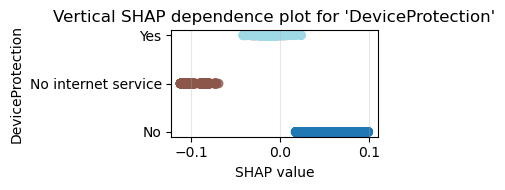

,mean_shap
category,
No internet service,-0.099293
Yes,-0.013376
No,0.039657


In [88]:
for feature in top_cat_features:
    plot_categorical_shap(shap_values,X, feature)